# Classical counterpart of the Quantum-Pennylane model

Basically we are just creating a small MLP model to compare its performance to the Quantum Dressed One

## Basic Imports

In [121]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

# Pennylane
import pennylane as qml
from pennylane import numpy as np


# Plotting
import matplotlib.pyplot as plt

## Seed everything for reproductibility

In [122]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.mps.manual_seed(seed)

In [123]:
seed_everything(0)

## Setting of the main hyper-parameters of the model

In [124]:
n_qubits = 3                # Number of qubits
q_depth = 6                 # Depth of the quantum circuit (number of variational layers)
q_delta = 0.01              # Initial spread of random quantum weights

In [125]:
BATCH_SIZE = 2048
EPOCHS = 50
LR = 1e-3
GAMMA_LR = 0.5    # Learning rate reduction applied every STEP_LR epochs.
STEP_LR = 20
WEIGHT_DECAY = 0

In [126]:
# Number of weights in the MLP should be q_depth * n_qubits. Here 6*3=18.

In [127]:
dev = qml.device("default.qubit", wires=n_qubits)

In [128]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Pennylane doesnt seem to support Mac Apple Silicon yet
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

print('Device used:', device)


Device used: mps


## Dataset loading

The dataset is created from 2 CSV file of size (80, 3) and (20, 3) respectively.

Each example has 3 features: Class, Sentence, Sentence_Embedding

In [129]:
def preprocess_single_dataset(csv_file):
    """
    Preprocess function for the dataset + Create train/test split
    """
    df_dataset = pd.read_csv(csv_file)

    df_dataset['sentence_embedding'] = np.array([np.fromstring(embedding.strip(' []'), sep=' ') for embedding in df_dataset['sentence_embedding']]).numpy().tolist()

    #Preprocess labels
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(df_dataset['class'].values.reshape(-1, 1))
    df_dataset['class'] = enc.transform(df_dataset['class'].values.reshape(-1, 1)).toarray().tolist()

    X_train, X_test, y_train, y_test = train_test_split(df_dataset['sentence_embedding'], df_dataset['class'], test_size=0.2)

    return X_train, X_test, y_train, y_test



In [130]:
def preprocess_train_test_dataset(train_csv_file, test_csv_file):
    """
    Preprocess function for the dataset + Create train/test split
    """
    df_train = pd.read_csv(train_csv_file)
    df_test = pd.read_csv(test_csv_file)


    df_train['sentence_embedding'] = np.array([np.fromstring(embedding.strip(' []'), sep=',') for embedding in df_train['sentence_embedding']]).tolist()
    df_test['sentence_embedding'] = np.array([np.fromstring(embedding.strip(' []'), sep=',') for embedding in df_test['sentence_embedding']]).tolist()

    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(df_train['class'].append(df_test['class']).values.reshape(-1, 1))
    
    df_train['class'] = enc.transform(df_train['class'].values.reshape(-1, 1)).toarray().tolist()
    df_test['class'] = enc.transform(df_test['class'].values.reshape(-1, 1)).toarray().tolist()

    X_train, y_train, X_test, y_test = df_train['sentence_embedding'], df_train['class'], df_test['sentence_embedding'], df_test['class']

    return X_train, X_test, y_train, y_test

In [131]:
class BertEmbeddingDataset(Dataset):
    """Bert Embedding dataset."""

    def __init__(self, X, Y):
        self.X = X
        self.Y = Y


    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return torch.tensor(self.X.iloc[idx]), torch.tensor(self.Y.iloc[idx])

In [132]:
#X_train, X_test, y_train, y_test = preprocess_single_dataset('../../../../data/amazonreview_reduced_bert_train_sentence.csv')
X_train, X_test, y_train, y_test = preprocess_train_test_dataset('../../../../data/toy_dataset/toy_dataset_bert_sentence_embedding_train.csv', '../../../../data/toy_dataset/toy_dataset_bert_sentence_embedding_test.csv')

/var/folders/6f/3fhw90n17t140lh7zgl3n7080000gq/T/ipykernel_77914/3575134540.py:13: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  enc.fit(df_train['class'].append(df_test['class']).values.reshape(-1, 1))


In [133]:
train_dataset = BertEmbeddingDataset(X_train, y_train)
training_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

validation_dataset = BertEmbeddingDataset(X_test, y_test)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [134]:
class BasicNet(nn.Module):
    """
    Torch module implementing the net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.pre_net = nn.Linear(768, n_qubits)
        self.counter_part_net = nn.Sequential(nn.Linear(n_qubits, 2),
                                    nn.LeakyReLU(0.01),
                                    nn.Linear(2, n_qubits),
                                    nn.LeakyReLU(0.01))
        #3*2 + 2*3 = 12 trainable weights and 2+3 = 5 trainable biases --> 17 trainable parameters
        self.post_net = nn.Linear(n_qubits, 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_features):
        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features)

        q_out = self.counter_part_net(pre_out)

        # return the two-dimensional prediction from the postprocessing layer
        return self.sigmoid(self.post_net(q_out))

In [135]:
model = BasicNet()

# Use CUDA or CPU according to the "device" object.
model = model.to(device)

## Training and results

Here we use a Binary Cross Entropy Loss, an Adam optimizer and a scheduler reducing the learning rate at an exponentially rate. 

In [136]:
criterion = nn.BCELoss()
optimizer_hybrid = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_hybrid, step_size=STEP_LR, gamma=GAMMA_LR
)


We use tensorboard to log the hyperparameters, the loss and the accuracy of the model:

In [137]:
from torch.utils.tensorboard import SummaryWriter
import datetime

log_dir = "logs/fit_pennylane_classical_counterpart/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
summary_writer = SummaryWriter(log_dir=log_dir)

In [138]:
#Training loop
best_val_loss = 1000
best_val_acc = 0
best_train_loss = 1000
best_acc_train = 0

training_loss_list = []
validation_loss_list = []
training_acc_list = []
validation_acc_list = []
print("Training started:")

epoch_bar = tqdm(range(EPOCHS), total=EPOCHS, desc="Epochs", position=0, leave=True)

for epoch in epoch_bar:

    model.train()

    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    it = 0
    training_bar = tqdm(training_dataloader, total=len(training_dataloader), desc="Training", position=0, leave=True)

    for inputs, labels in training_bar:
        batch_size_ = len(inputs)
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer_hybrid.zero_grad()

        # Track/compute gradient and make an optimization step only when training
        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            
            loss.backward()
            optimizer_hybrid.step()

        # Print iteration results
        running_loss += loss.item()*batch_size_

        batch_corrects = torch.sum(preds == torch.max(labels, 1)[1]).item()
        running_corrects += batch_corrects

        training_bar.set_postfix({"loss": f"{loss:.3f}", "acc": f"{batch_corrects/batch_size_:.3f}"})


    # Print epoch results
    train_loss = running_loss / len(training_dataloader.dataset)
    train_acc = running_corrects / len(training_dataloader.dataset)

    epoch_bar.set_postfix({"loss": f"{train_loss:.3f}", "acc": f"{train_acc:.3f}"})

    summary_writer.add_scalar("Training/Loss", train_loss, epoch)
    summary_writer.add_scalar("Training/Acurracy", train_acc, epoch)

    training_loss_list.append(train_loss)
    training_acc_list.append(train_acc)

    exp_lr_scheduler.step()

    if train_loss < best_train_loss:
        best_train_loss = train_loss

    if train_acc > best_acc_train:
        best_acc_train = train_acc

    
    ## VALIDATION PHASE
    validation_bar = tqdm(validation_dataloader, total=len(validation_dataloader), desc="Validation", position=0, leave=True)
    model.eval()

    running_loss = 0.0
    running_corrects = 0


    for inputs, labels in validation_bar:
        batch_size_ = len(inputs)
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer_hybrid.zero_grad()

        # Track/compute gradient and make an optimization step only when training
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        # Print iteration results
        running_loss += loss.item()*batch_size_
        batch_corrects = torch.sum(preds == torch.max(labels, 1)[1]).item()
        running_corrects += batch_corrects

        validation_bar.set_postfix({"loss": f"{loss:.3f}", "acc": f"{batch_corrects/batch_size_:.3f}"})
        it += 1

    validation_loss = running_loss / len(validation_dataloader.dataset)
    validation_acc = running_corrects / len(validation_dataloader.dataset)

    summary_writer.add_scalar("Validation/Loss", validation_loss, epoch)
    summary_writer.add_scalar("Validation/Acurracy", validation_acc, epoch)

    validation_loss_list.append(validation_loss)
    validation_acc_list.append(validation_acc)

    if validation_acc > best_val_acc:
        best_val_acc = validation_acc

    if validation_loss < best_val_loss:
        best_val_loss = validation_loss

    exp_lr_scheduler.step()



Training started:


Epochs: 100%|██████████| 50/50 [00:01<00:00, 48.33it/s, loss=0.674, acc=0.588]


In [139]:
summary_writer.add_hparams({'lr': LR, 'gamma_lr': GAMMA_LR, 'step_lr': STEP_LR, 'weight_decay': WEIGHT_DECAY},
                      {'hparam/loss_train': best_train_loss, 'hparam/acc_train': best_acc_train,
                       'hparam/loss_valid': best_val_loss, 'hparam/acc_valid': best_val_acc})

## Display loss and accuracy results

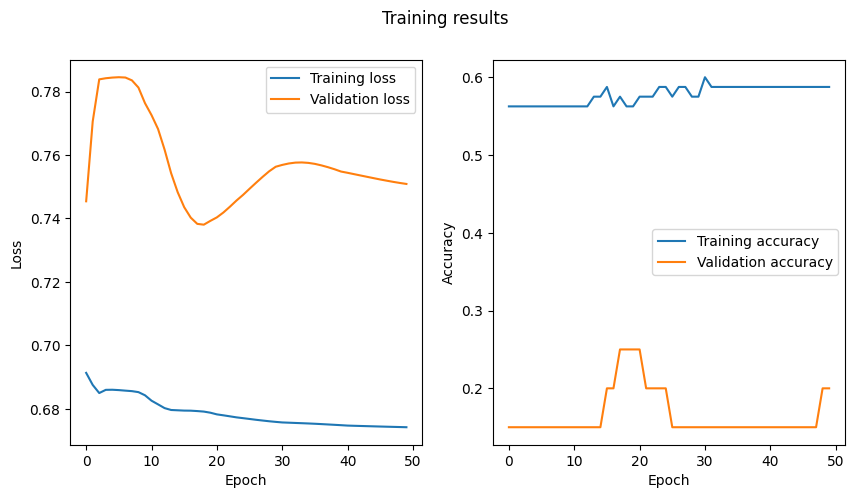

In [140]:
fig, ax1 = plt.subplots(1,2)

# Plot Training and Validation Loss
ax1[0].plot(training_loss_list, label='Training loss')
ax1[0].plot(validation_loss_list, label='Validation loss')
ax1[0].legend()
ax1[0].set_ylabel('Loss')
ax1[0].set_xlabel('Epoch')

# Plot Training and Validation Accuracy
ax1[1].plot(training_acc_list, label='Training accuracy')
ax1[1].plot(validation_acc_list, label='Validation accuracy')
ax1[1].legend()
ax1[1].set_ylabel('Accuracy')
ax1[1].set_xlabel('Epoch')


fig.suptitle('Training results')
fig.set_size_inches(10, 5)